## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.2


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
dataset = nlp.load_dataset('emotion')

In [4]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [13]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets,labels


In [14]:
tweets, labels = get_tweet(train)

In [15]:
tweets[1], labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [17]:
tokenizer = Tokenizer(num_words=1000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [18]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [19]:
tweets[0]

'i didnt feel humiliated'

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

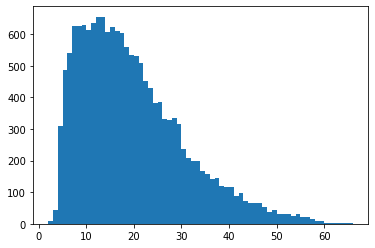

In [20]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins= len(set(lengths)))
plt.show()

In [21]:
maxlen = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [22]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [23]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [24]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [25]:
classes = set(labels)
print(classes)


{'fear', 'surprise', 'love', 'joy', 'sadness', 'anger'}


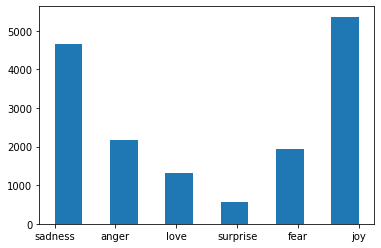

In [26]:
plt.hist(labels, bins=11)
plt.show()

In [27]:
class_to_index = dict((c, i) for i,c in enumerate(classes))
index_to_class = dict((v, k) for k,v in class_to_index.items())

In [28]:
class_to_index

{'fear': 0, 'surprise': 1, 'love': 2, 'joy': 3, 'sadness': 4, 'anger': 5}

In [29]:
index_to_class

{0: 'fear', 1: 'surprise', 2: 'love', 3: 'joy', 4: 'sadness', 5: 'anger'}

In [32]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [33]:
train_labels = names_to_ids(labels)
print(train_labels[0])

4


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [34]:
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [36]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [37]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 4)

In [39]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 7s 13ms/step - loss: 0.5055 - accuracy: 0.8303 - val_loss: 0.5017 - val_accuracy: 0.8325
Epoch 2/20
500/500 [==============================] - 10s 21ms/step - loss: 0.4034 - accuracy: 0.8619 - val_loss: 0.4416 - val_accuracy: 0.8545
Epoch 3/20
500/500 [==============================] - 10s 19ms/step - loss: 0.3593 - accuracy: 0.8749 - val_loss: 0.4072 - val_accuracy: 0.8565
Epoch 4/20
500/500 [==============================] - 9s 18ms/step - loss: 0.3295 - accuracy: 0.8806 - val_loss: 0.4070 - val_accuracy: 0.8570
Epoch 5/20
500/500 [==============================] - 6s 12ms/step - loss: 0.3030 - accuracy: 0.8881 - val_loss: 0.4199 - val_accuracy: 0.8545
Epoch 6/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2886 - accuracy: 0.8927 - val_loss: 0.4015 - val_accuracy: 0.8650
Epoch 7/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2723 - accuracy: 0.9016 - val_loss: 0.4193 - val_accuracy: 0.86

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

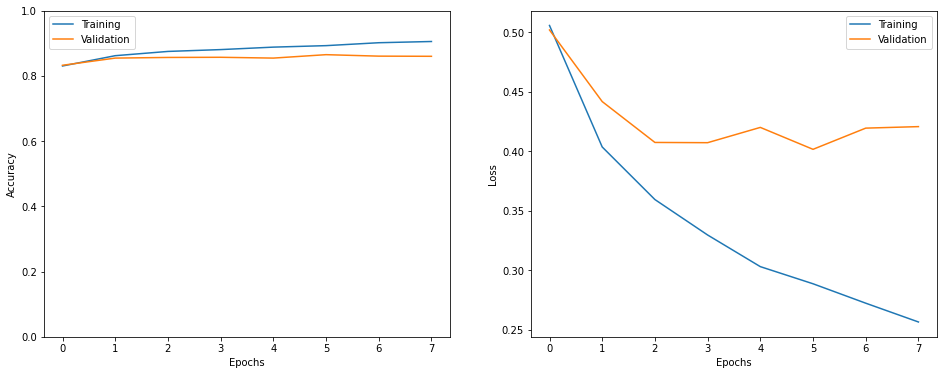

In [40]:
show_history(h)

In [42]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [44]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 7ms/step - loss: 0.3990 - accuracy: 0.8560


In [63]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]
print('Predicted Emotion:', pred_class)

Sentence: i have a feeling itll be a little more messy going home though
Emotion: sadness
Predicted Emotion: sadness


In [71]:
preds = model.predict(test_seq)
classes_x=np.argmax(preds,axis=1)

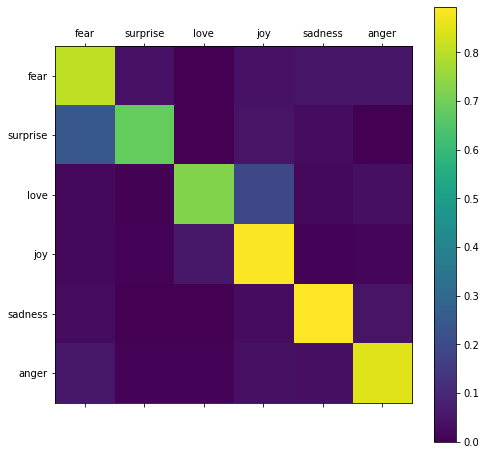

In [73]:
show_confusion_matrix(test_labels, classes_x, list(classes))